In [343]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [338]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K

Using Theano backend.


## Helper fcns

In [96]:
def LOSOCV(Data,X,y,groups,models):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; 
        acc_all=[]; acc_train=[] #sens and spec for current model and all subject
        f1_test_all=[]; prec_all=[]; rec_all=[]; auprc_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            #f1-score, prec and recall, auprc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            
            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            
        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all)))
          


#             #compute Sens and Spec for current subject and classifier
#             if np.sum(yte==1)>0:                    
#                 Sens = sum((ypred==1)&( yte==1))/sum(yte==1)
#             else:
#                 print('%s has no positive examples'%Data.Subject[test_index].unique())
#                 Sens = np.nan
#             if np.sum(yte==0)>0:
#                 Spec = sum((ypred==0) & (yte==0))/sum(yte==0)
#             else:
#                 Spec = np.nan
#                 print('%s has no negative examples'%Data.Subject[test_index].unique())
#             Sens_all.append(Sens); Spec_all.append(Spec)
#             #compute accuracy
#             acc = sum(ypred==yte)/len(yte)
#             acc_all.append(acc)
        
        #mean across all subjects
#         print(('%s, mean Acc on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_train),2*np.nanstd(acc_train)/np.sqrt(len(acc_train))))
#         print(('%s, mean Sens = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Sens_all),2*np.nanstd(Sens_all)/np.sqrt(len(Sens_all))))
#         print(('%s, mean Spec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Spec_all),2*np.nanstd(Spec_all)/np.sqrt(len(Spec_all))))
#         print(('%s, mean Acc = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_all),2*np.nanstd(acc_all)/np.sqrt(len(acc_all))))
        
       
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [3]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

### CNN functions

In [382]:
# useful functions
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))

    return X_train, X_valid


def model_conv(model):
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_eval(X_valid,y_valid):
    fig=plt.figure()
    fig.add_subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    fig.add_subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('accuracy')
    plt.legend(['train','test'],loc='best')

    #performance eval
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_true = np.argmax(y_valid, axis=1)
    y_score = model.predict(X_valid)
    
    f1_test=f1_score(y_true,y_pred)
    Prec = precision_score(y_true,y_pred)
    Rec = recall_score(y_true,y_pred)
    precision, recall, _ = precision_recall_curve(y_true,y_score)
    auprc = auc(recall,precision)

    print('f1_test=%.3f, Prec=%.3f, Rec=%.3f, auprc=%.3f'%(f1_test,Prec,Rec,auprc))
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
    print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))

def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    acc = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(acc,axis=0)
    s = np.std(acc,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(5,10):
            print(np.std(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

### Load data

In [4]:
#load feature matrix - TREMOR
# Data = pd.read_csv(os.path.join(features_path,'Datatremor.csv')) #band-pass filter 3-8 Hz
# Data = pd.read_csv(os.path.join(features_path,'Databradykinesia.csv')) #low-pass 3 Hz
Data = pd.read_csv(os.path.join(features_path,'Data.csv')) #only HP filter
print(Data.shape)
Data.head(2)

(28499, 44)


,Unnamed: 0,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.007757,0.010663,0.006639,...,0.001943,3.019358,8.685826,0.000318,0.039815,-0.184625,12.745926,0.632860,0.662610,0.612830
1,1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.007055,0.010101,0.006168,...,0.001101,2.173485,4.459587,0.000191,0.025149,-0.091885,0.860041,0.621925,0.629151,0.538592


In [25]:
Data.Location.unique()

array(['dorsal_hand_left', 'dorsal_hand_right'], dtype=object)

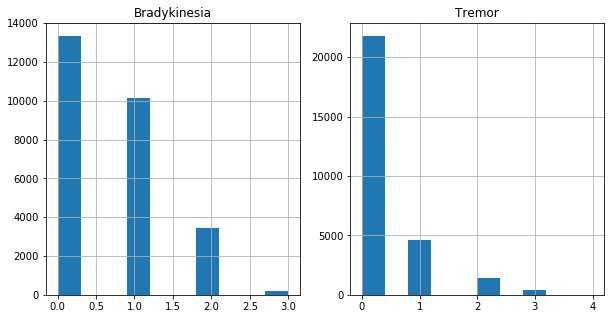

In [6]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

How many instances of symptoms (>0) we have per subject and task

(<matplotlib.text.Text at 0x1126d2da0>, <matplotlib.text.Text at 0x11256e1d0>)

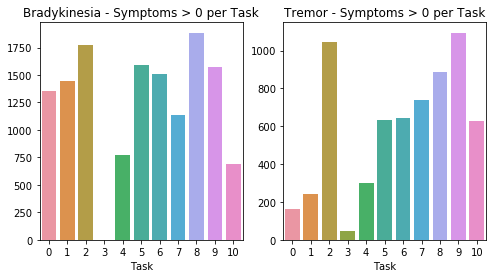

In [17]:
BradP=[]; TremorP=[]
for t in Data['Task'].unique():
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0))
    TremorP.append(sum(d['Tremor'] > 0))

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(<matplotlib.text.Text at 0x11284e3c8>, <matplotlib.text.Text at 0x111f7a0f0>)

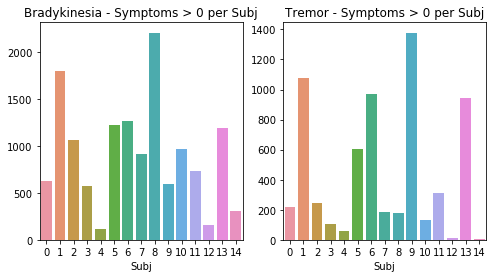

In [19]:
BradP=[]; TremorP=[]
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0))
    TremorP.append(sum(d['Tremor'] > 0))

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')


## Organize target scores into array

In [37]:
# symptom = 'Bradykinesia'
symptom = 'Tremor'

In [38]:
#rows with symptoms 
indp = ((Data[symptom]>0))
indp = indp.values

In [39]:
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

Rows w Tremor 6421/28499 = 0.23


# PCA on features to visualize subjects with symptom


In [40]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [41]:
#standardize features
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)
print(X.shape)

(28499, 37)


total explained variance ratio (first 10 components): 0.698
[ 0.25546264  0.11378354  0.07891475  0.0557975   0.04323559  0.03197158
  0.03068572  0.03004261  0.02988952  0.02823359]


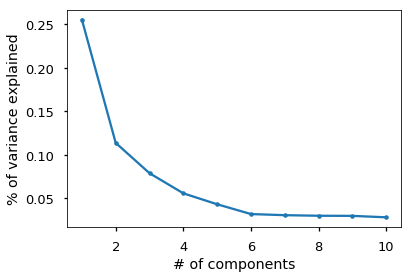

In [42]:
%matplotlib inline
nC = 10
pca = PCA(n_components=nC)
Xpca = pca.fit(X_std).transform(X_std)
# Percentage of variance explained for each components
print('total explained variance ratio (first %d components): %.3f'%(nC, pca.explained_variance_ratio_[0:nC].sum()))
print(pca.explained_variance_ratio_[:10])
ax = plt.plot(range(1,nC+1),pca.explained_variance_ratio_,'.-')
plt.xlabel('# of components')
plt.ylabel('% of variance explained')

In [43]:
Xpca.shape

(28499, 10)

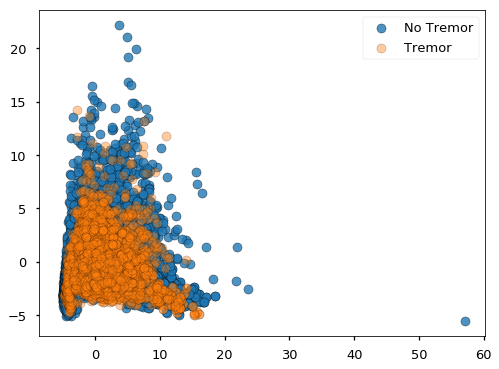

In [44]:
sns.set_context('talk')
fig = plt.figure(figsize=(8,6))
plt.scatter(Xpca[~indp,0],Xpca[~indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.8,label='No '+symptom)
plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label=symptom)
plt.legend()

# Fit some classifiers to data using LOSOCV

In [60]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [61]:
#LOSO CV
groups = Data.Subject.as_matrix()

In [63]:
#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)
print(X_std.shape)

(28499, 37)


In [95]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    LOSOCV(Data,X_std,y,groups,models)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 6421/28499 = 0.23
Training Random Forest
f1_test=0.256+/-0.196, prec=0.438+/-0.282, rec=0.225+/-0.185, auprc=0.398+/-0.258
Training XGB
f1_test=0.241+/-0.179, prec=0.467+/-0.294, rec=0.203+/-0.189, auprc=0.414+/-0.264
Rows w Bradykinesia 13734/28499 = 0.48
Training Random Forest
f1_test=0.531+/-0.128, prec=0.563+/-0.205, rec=0.558+/-0.133, auprc=0.582+/-0.210
Training XGB
f1_test=0.554+/-0.121, prec=0.555+/-0.195, rec=0.620+/-0.131, auprc=0.574+/-0.206


## Try with k-fold CV

In [98]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 6421/28499 = 0.23
Random Forest
f1_train=1.000+/-0.000, f1_test=0.556+/-0.008, prec=0.843+/-0.016, rec=0.415+/-0.010, auprc=0.736+/-0.005
[[4294  121]
 [ 743  541]]
XGB
f1_train=0.468+/-0.006, f1_test=0.447+/-0.015, prec=0.758+/-0.010, rec=0.317+/-0.014, auprc=0.637+/-0.005
[[4279  136]
 [ 843  441]]
Rows w Bradykinesia 13734/28499 = 0.48
Random Forest
f1_train=1.000+/-0.000, f1_test=0.758+/-0.005, prec=0.773+/-0.004, rec=0.743+/-0.008, auprc=0.850+/-0.003
[[2338  615]
 [ 731 2015]]
XGB
f1_train=0.721+/-0.002, f1_test=0.703+/-0.009, prec=0.693+/-0.008, rec=0.714+/-0.011, auprc=0.758+/-0.008
[[2040  913]
 [ 823 1923]]


In [109]:
t1=time.time()
for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('\nRows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=True)

print('Elapsed time = %.3f'%(round(time.time()-t1)))


Rows w Tremor 6421/28499 = 0.23
Npos = 5137, Nneg = 5137
Random Forest
f1_train=1.000+/-0.000, f1_test=0.613+/-0.007, prec=0.505+/-0.010, rec=0.781+/-0.010, auprc=0.698+/-0.009
[[3401 1014]
 [ 291  993]]
Npos = 5137, Nneg = 5137
XGB
f1_train=0.784+/-0.004, f1_test=0.570+/-0.010, prec=0.458+/-0.010, rec=0.755+/-0.017, auprc=0.627+/-0.006
[[3259 1156]
 [ 302  982]]

Rows w Bradykinesia 13734/28499 = 0.48
Npos = 10988, Nneg = 10988
Random Forest
f1_train=1.000+/-0.000, f1_test=0.763+/-0.009, prec=0.758+/-0.009, rec=0.767+/-0.010, auprc=0.848+/-0.005
[[2245  708]
 [ 672 2074]]
Npos = 10988, Nneg = 10988
XGB
f1_train=0.735+/-0.001, f1_test=0.707+/-0.009, prec=0.678+/-0.008, rec=0.739+/-0.012, auprc=0.757+/-0.009
[[1941 1012]
 [ 767 1979]]
Elapsed time = 131.000


## Recall per Task

## CNN on rawdata

In [154]:
data = pd.read_hdf('../FeatureMatrix/DataRawclips.hdf5')

In [155]:
data.head()

,Subject,Visit,Task,Location,Bradykinesia,Tremor,acc_xyz,gyr_xyz
0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,"[[0.00442182590312, -0.0200148763835, -0.01990...","[[2.41092545968, 28.7174792096, 1.80056458381]..."
1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,"[[-0.0607082544856, -0.0905657087803, 0.064953...","[[-54.4136720836, 12.9701686122, 110.688944839..."
2,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,"[[0.220442267724, 0.152858651212, 0.1146350880...","[[-45.2582589456, 7.66002899214, 38.7884336614..."
3,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,"[[-0.000921648804147, -0.0425384594624, 0.1049...","[[-10.7118333715, -65.6443121996, 15.411612115..."
4,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,"[[0.055472374389, 0.0319095435029, -0.09051654...","[[62.3483634699, 23.9566643778, -94.8805981537..."


In [156]:
len(data)

27805

In [ ]:
# data['acclen']=data.apply()

In [264]:
#unpack clips, scores, subj and task data
le = LabelEncoder()
acc = data.acc_xyz.values
gyr = data.gyr_xyz.values
scores_brady = data.Bradykinesia
scores_tremor = data.Tremor
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)

### Resample data

In [267]:
#check clips with less than 313 samples and resample
la=[]; lg=[]
for i in range(len(acc)):
    la.append(acc[i].shape[0])
    lg.append(gyr[i].shape[0])

print(np.unique(lg))

#resample all clips to 313 samples (62.5 Hz)
# accres = []
num = 313
accres = np.zeros((len(acc),num,3) )
gyrres = np.zeros((len(gyr),num,3) )
for i in range(len(acc)):
    if len(acc[i]<num):
        accres[i,:,0] = resample(acc[i][:,0],num)
        accres[i,:,1] = resample(acc[i][:,1],num)
        accres[i,:,2] = resample(acc[i][:,2],num)
    else: 
        accres[i,:,:] = acc[i].copy()
        
    if len(gyr[i]<num):
        gyrres[i,:,0] = resample(acc[i][:,0],num)
        gyrres[i,:,1] = resample(acc[i][:,1],num)
        gyrres[i,:,2] = resample(acc[i][:,2],num)
    else:
        gyrres[i,:,:] = acc[i].copy()

[313]


In [ ]:
acc = accres
gyr = gyrres

In [288]:
def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    acc = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(acc,axis=0)
    s = np.std(acc,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(0,5):
            print(np.mean(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

In [295]:
accn = stdclipdata(acc,False)
gyrn = stdclipdata(gyr,False)

### Train CNN on bradykinesia data
* accelerometer only

In [333]:
X = accn.copy()
y = scores_brady.values
print(X.shape)
print(y.shape)

(27805, 313, 3)
(27805,)


In [335]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [425]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10])

In [337]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(26449, 313, 3)
(26449,)
(26449,)
(26449,)
(26449,)


In [346]:
#binarize labels
y[y>0] = 1

In [371]:
#load clips, standardize and split data into train and valid set
def prepare_data(X,y,network_type,balance=False):
    
    #standardize all data (note - should std training and apply on test)
#     Xn = stdclipdata(X)
#     Xn = X
    
    #perform a random train_valid split first to test approach
    inds = np.arange(0,len(y))
    X_train,X_valid,y_train,y_valid,inds_train,inds_valid = train_test_split(X,y,inds,test_size=0.2,stratify=task,random_state=32)
    print('X_train = ')
    print(X_train.shape)
    print('X_valid = ')
    print(X_valid.shape)
    
    #balance training dataset
    if balance:
        indsp = np.where(y_train==1)[0]
        indsn = np.random.choice(np.where(y_train==0)[0],size=round(1.5*len(indsp)),replace=False)
        inds = np.hstack((indsp,indsn))
        X_train=X_train[inds]
        y_train=y_train[inds]

    num_classes = 2 # 
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    
    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)
    print('X_train = ')
    print(X_train.shape)

    return X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim

In [372]:
X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim = prepare_data(X,y,'CNN')

X_train = 
(21159, 313, 3)
X_valid = 
(5290, 313, 3)
reshaping data for different models ...
CNN
X_train = 
(21159, 3, 313, 1)


In [373]:
#swap axes to have channel as last dim
X_train = np.swapaxes(X_train,1,3)
X_valid = np.swapaxes(X_valid,1,3)
print(X_train.shape)

(21159, 1, 313, 3)


In [376]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes =2 

In [377]:
print('building the model ...')
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(1, 6)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 313, 16)        1552      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 78, 16)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 78, 16)         4112      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 13, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 208)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                6688      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)              

In [378]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/20
21159/21159 [==============================] - 7s - loss: 0.7025 - acc: 0.5203 - val_loss: 0.6858 - val_acc: 0.5815
Epoch 2/20
21159/21159 [==============================] - 7s - loss: 0.6843 - acc: 0.5578 - val_loss: 0.6718 - val_acc: 0.6066
Epoch 3/20
21159/21159 [==============================] - 8s - loss: 0.6711 - acc: 0.5922 - val_loss: 0.6540 - val_acc: 0.6278
Epoch 4/20
21159/21159 [==============================] - 8s - loss: 0.6489 - acc: 0.6270 - val_loss: 0.6298 - val_acc: 0.6501
Epoch 5/20
21159/21159 [==============================] - 8s - loss: 0.6374 - acc: 0.6419 - val_loss: 0.6229 - val_acc: 0.6544
Epoch 6/20
21159/21159 [==============================] - 8s - loss: 0.6216 - acc: 0.6632 - val_loss: 0.6044 - val_acc: 0.6671
Epoch 7/20
21159/21159 [==============================] - 8s - loss: 0.6181 - acc: 0.6683 - val_loss: 0.5959 - val_acc: 0.6796
Epoch 8/20
21159/21159 [===================

f1_test=0.771, Prec=0.736, Rec=0.809
[[1808  783]
 [ 516 2183]]
the mean f1 score:0.76


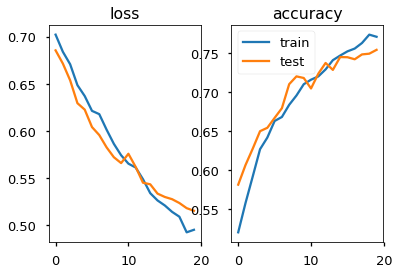

In [379]:
model_eval(X_valid,y_valid)

after 20 epochs it starts to overfit

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/20
21159/21159 [==============================] - 7s - loss: 0.4864 - acc: 0.7751 - val_loss: 0.5151 - val_acc: 0.7580
Epoch 2/20
21159/21159 [==============================] - 7s - loss: 0.4756 - acc: 0.7840 - val_loss: 0.5221 - val_acc: 0.7486
Epoch 3/20
21159/21159 [==============================] - 7s - loss: 0.4764 - acc: 0.7816 - val_loss: 0.5113 - val_acc: 0.7569
Epoch 4/20
21159/21159 [==============================] - 8s - loss: 0.4658 - acc: 0.7913 - val_loss: 0.5152 - val_acc: 0.7535
Epoch 5/20
21159/21159 [==============================] - 8s - loss: 0.4591 - acc: 0.7946 - val_loss: 0.5265 - val_acc: 0.7520
Epoch 6/20
21159/21159 [==============================] - 8s - loss: 0.4581 - acc: 0.7948 - val_loss: 0.5082 - val_acc: 0.7569
Epoch 7/20
21159/21159 [==============================] - 7s - loss: 0.4610 - acc: 0.7923 - val_loss: 0.5157 - val_acc: 0.7520
Epoch 8/20
21159/21159 [===================

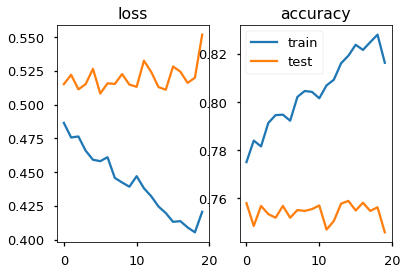

In [380]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))
model_eval(X_valid,y_valid)

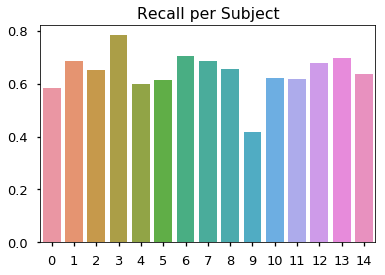

In [405]:
#recall rate per subject
y_pred = np.argmax(model.predict(X_valid),axis=1)
y_valid = np.argmax(y_valid,axis=1)
subj_valid=subj[inds_valid]

RecS = []
for s in np.unique(subj_valid):

    indS = np.where(subj_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.arange(len(RecS)),y=RecS)
plt.title('Recall per Subject')

In [428]:
np.unique(task_valid)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10])

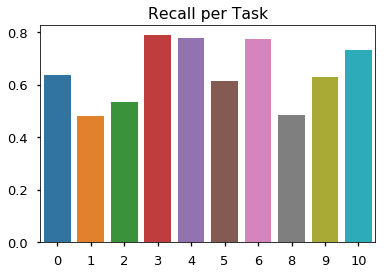

In [429]:
#recall rate per task
y_pred = np.argmax(model.predict(X_valid),axis=1)
# y_valid = np.argmax(y_valid,axis=1)
task_valid=task[inds_valid]

RecS = []
for s in np.unique(task_valid):

    indS = np.where(task_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.unique(task_valid),y=RecS)
plt.title('Recall per Task')
plt.xticks()

In [418]:
task[inds_valid]

array([10,  0,  0, ...,  9,  1,  9])

In [417]:
np.unique(task[inds_valid])

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10])

In [415]:
len(np.unique(Data.Task))

11

In [407]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

In [412]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


## Feature importance

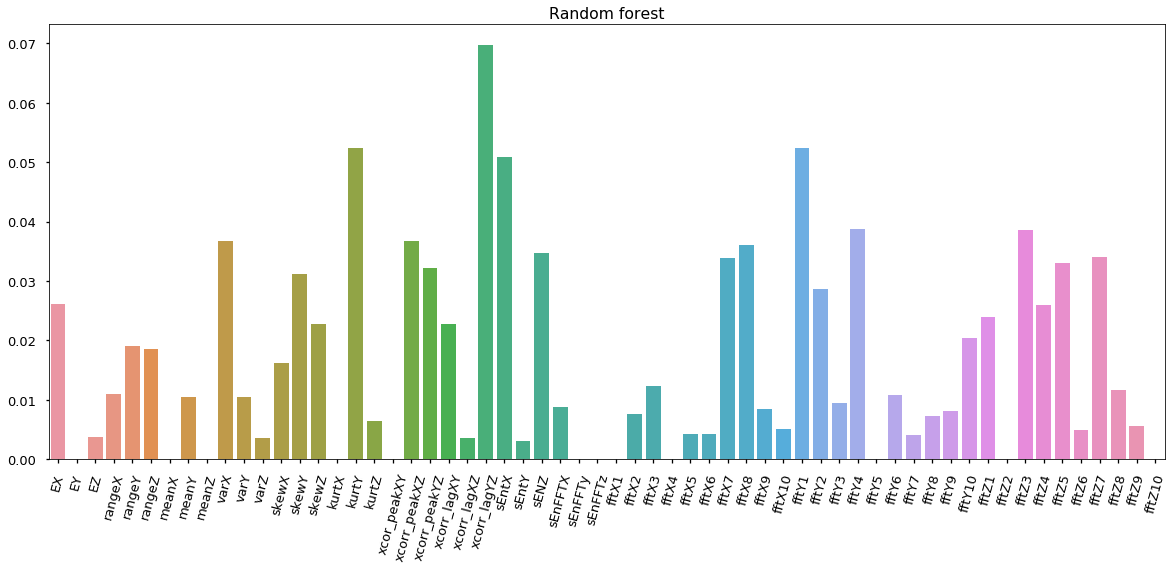

In [181]:
clf = models[1][0]
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('Random forest')

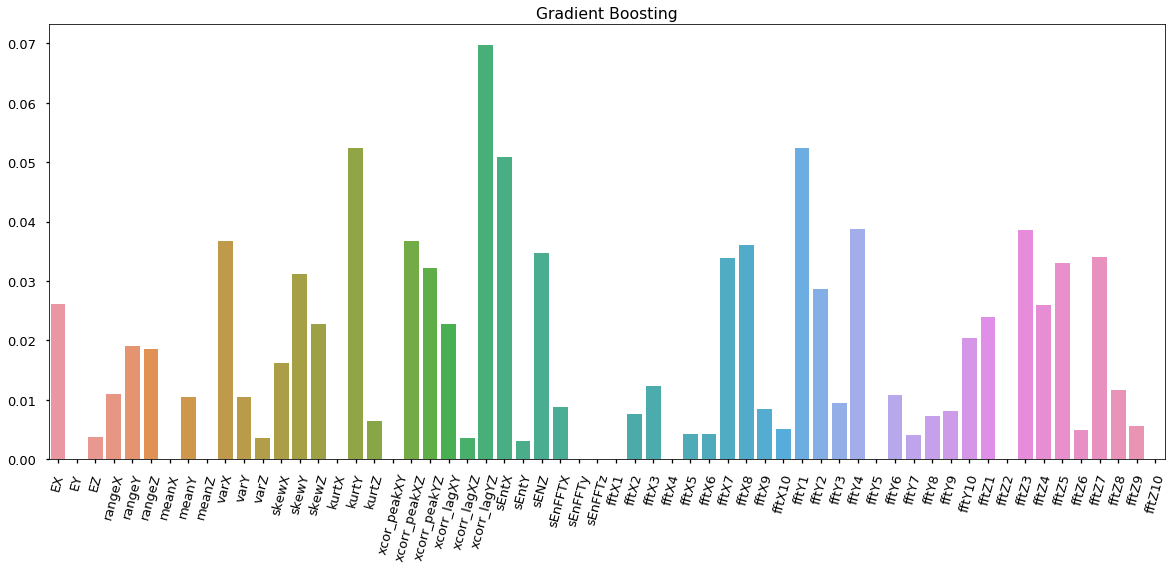

In [180]:
clf = models[2][0]
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('Gradient Boosting')

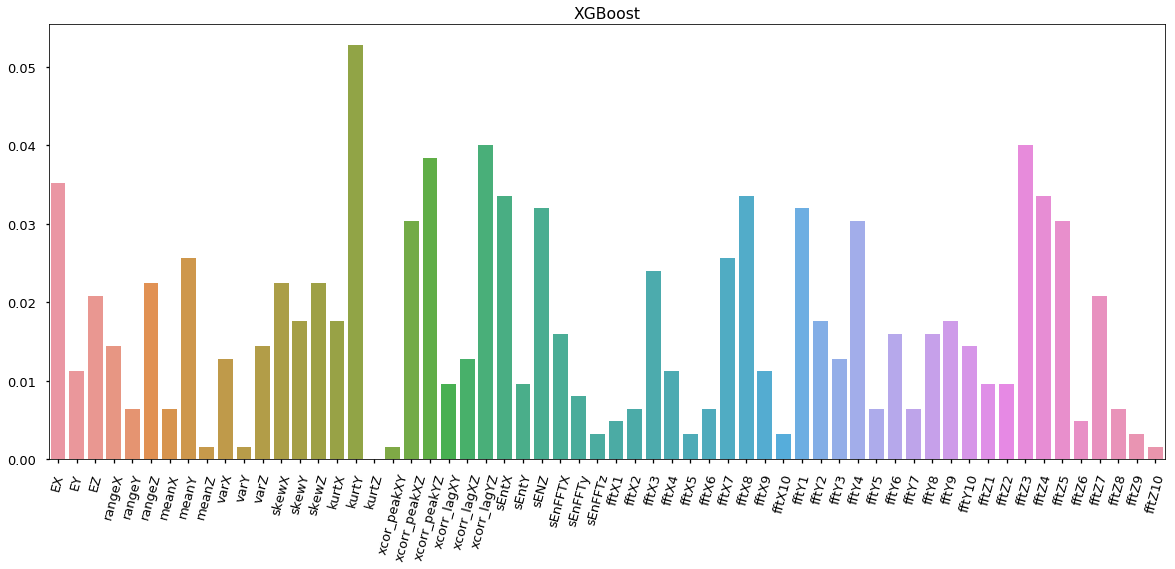

In [187]:
clf = models[4][0]
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('XGBoost')